<a href="https://colab.research.google.com/github/shivani1912/Venmo_User_Analysis/blob/master/Venmo_User_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background
Venmo is a peer-to-peer (P2P) mobile payment app owned by PayPal. The Venmo app allows its users to exchange money with just a click of a button. In the fourth quarter of 2019, Venmo’s net payment volume amounted to 29 billion U.S. dollars, representing a 56 percent year-on-year growth, and its user-base had more than 40 million active accounts . 1 What made Venmo so popular in the US is its social flavor; users are required to accompany their transactions with a message describing what the transaction was about. This social twist has allowed Venmo to
transform financial transactions into sharing experiences.

## Objective
In this project, we analyze the user's social network and spending behaviors to predict the total transactions transacted by the user in the first year akin to Customer Lifetime Value.

# Text Analytics
Venmo data offers a unique opportunity to see what people are spending their money on. However, the most challenging part in figuring out such a thing is to have the right “lexicon” (most of them are proprietary and for a reason, as you will hopefully realise). Venmo messages can be 1) emoji, 2) text and 3) a combination of emoji and text.

For emoji, we have an emoji classification dictionary that includes all emoji and their categories (By scraping emojipedia.com).

Text, however, is harder to classify. We have created a word classification dictionary.
 In this dictionary, words are divided into 9 topics: 1) People (usually, words that indicate emotions towards others), 2) Food, 3) Event, 4) Activity, 5) Travel (note that Travel is a subset of Activity, but in my opinion required to be a different topic), 6) Transportation, 7) Utility, 8) Cash and 9) Illegal/Sarcasm (as you will notice, there are many bad words in there, and it’s hard to distinguish if they are used as sarcasm or if they are used for illegal activities.

In [ ]:
# Install all neccessary packages for our analysis
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install emoji

spark-3.0.0-preview2-bin-hadoop2.7/
spark-3.0.0-preview2-bin-hadoop2.7/data/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/AFINN-111.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_binary_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_kmeans_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_multiclass_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_lda_libsvm_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/iris_libsvm.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pagerank_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_linear_regression_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pic_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/test.data
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/sample_movielens_rati

# Loading data

Installing spark & Importing all packages

In [ ]:
import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from google.colab import files

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession, Window
from google.colab import files
from pyspark.sql import functions as f
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType, MapType
from emoji import UNICODE_EMOJI
import emoji
from collections import Counter
from itertools import chain
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover

In [ ]:
#upload_f=files.upload()
# initialise sparkContext
spark = SparkSession\
            .builder\
            .appName('Venmo Classification')\
            .getOrCreate()

Mounting drive and loading transaction data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# For windows, change "drive" to "gdrive"
path='/content/drive/My Drive/VenmoSample.snappy.parquet'
input_parq= spark\
                  .read\
                  .option('header','true')\
                  .option('inferSchema','true')\
                  .parquet(path)

In [ ]:
input_parq.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)



## Classifying Venmo’s transactions
Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset.

In [ ]:
# We will work with a subset of 50k rows
input_parq = spark.createDataFrame(input_parq.take(50000))

In [ ]:
input_parq.show()

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5751b185cd03c9af2...|
| 2960727|3442373|         payment|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|
| 3977544|2709470|         payment|2016-09-29 22:12:07|          Chipotlaid|      false|57ed2f4723e064eac...|
| 3766386|4

In [ ]:
input_parq.select('story_id').distinct().count()

7113104

## Cleaning description data
Splitting & Tokenization


Extracting all words to one column


In [ ]:
sentenceData=input_parq.withColumn('clean_text',regexp_replace('description',"\\p{So}+",''))

In [ ]:
sentenceData.select([c for c in sentenceData.columns if c in ['description','clean_text']]).show()

+--------------------+--------------------+
|         description|          clean_text|
+--------------------+--------------------+
|                Uber|                Uber|
|              Costco|              Costco|
|        Sweaty balls|        Sweaty balls|
|                  🎥|                    |
|                   ⚡|                    |
|          Chipotlaid|          Chipotlaid|
|     kitchen counter|     kitchen counter|
|                Food|                Food|
|               Zaxby|               Zaxby|
|           Fan sucks|           Fan sucks|
|                  👠|                    |
|         Thanks babe|         Thanks babe|
|                  🍺|                    |
|                   ⛽|                    |
|Hey man  it's bee...|Hey man  it's bee...|
|         Getaway car|         Getaway car|
|     🔮 gypsy things|        gypsy things|
|                  🔴|                    |
|           Furniture|           Furniture|
|bed bath mostly b...|bed bath mostly

In [ ]:
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

In [ ]:
wordsData.show(15)

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|          clean_text|               words|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|                Uber|              [uber]|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|              Costco|            [costco]|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|        Sweaty balls|     [sweaty, balls]|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5

Extracting all emojis to one column

In [ ]:
TokenizedData = wordsData.withColumn('Emojis',regexp_extract(col('description'),"\\p{So}+",0))

In [ ]:
TokenizedData.show(10)

+-------+-------+----------------+-------------------+---------------+-----------+--------------------+---------------+------------------+------+
|  user1|  user2|transaction_type|           datetime|    description|is_business|            story_id|     clean_text|             words|Emojis|
+-------+-------+----------------+-------------------+---------------+-----------+--------------------+---------------+------------------+------+
|1218774|1528945|         payment|2015-11-27 10:48:19|           Uber|      false|5657c473cd03c9af2...|           Uber|            [uber]|      |
|5109483|4782303|         payment|2015-06-17 11:37:04|         Costco|      false|5580f9702b64f70ab...|         Costco|          [costco]|      |
|4322148|3392963|         payment|2015-06-19 07:05:31|   Sweaty balls|      false|55835ccb1a624b14a...|   Sweaty balls|   [sweaty, balls]|      |
| 469894|1333620|          charge|2016-06-03 23:34:13|             🎥|      false|5751b185cd03c9af2...|               |      

In [ ]:
# Create function to separate split emojis in a string to arrays
def emoji_splitter(text):
    new_string = ""
    for char in text:
        if char in emoji.UNICODE_EMOJI:
            new_string += " {} ".format(char)
        else:
            new_string += char
    return [v for v in map(lambda x: x.strip(), new_string.split(" ")) if v != ""]

In [ ]:
# UDF-ize for Spark
cool_udf = udf(lambda z: emoji_splitter(z), StringType())

In [ ]:
# Create a new column that splits the emojis
TokenizedData= TokenizedData.withColumn("split_emojis",cool_udf(TokenizedData.Emojis))

In [ ]:
TokenizedData.show(10)

+-------+-------+----------------+-------------------+---------------+-----------+--------------------+---------------+------------------+------+------------+
|  user1|  user2|transaction_type|           datetime|    description|is_business|            story_id|     clean_text|             words|Emojis|split_emojis|
+-------+-------+----------------+-------------------+---------------+-----------+--------------------+---------------+------------------+------+------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|           Uber|      false|5657c473cd03c9af2...|           Uber|            [uber]|      |          []|
|5109483|4782303|         payment|2015-06-17 11:37:04|         Costco|      false|5580f9702b64f70ab...|         Costco|          [costco]|      |          []|
|4322148|3392963|         payment|2015-06-19 07:05:31|   Sweaty balls|      false|55835ccb1a624b14a...|   Sweaty balls|   [sweaty, balls]|      |          []|
| 469894|1333620|          charge|2016-06-03 2

Delete Stop words (StopWordsRemover)


In [ ]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
wordsData=remover.transform(TokenizedData)
wordsData.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+------------+---------------+------+------------+---------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|  clean_text|          words|Emojis|split_emojis|       filtered|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+------------+---------------+------+------------+---------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|        Uber|         [uber]|      |          []|         [uber]|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|      Costco|       [costco]|      |          []|       [costco]|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|Sweaty balls|[sweaty, balls]|      |          []|[sweaty, balls]|
| 46

In [ ]:
# For windows, change "drive" to "gdrive"
dict_path='/content/drive/My Drive/Colab Notebooks/Bigdata_Venmo/Venmo_Emoji_Classification_Dictionary.csv'
input_emoji= spark\
                  .read\
                  .option('header','true')\
                  .option('inferSchema','true')\
                  .csv(dict_path)

## Uploading Emoji Dictionary





In [ ]:
emoji_df = pd.read_csv(dict_path)

In [ ]:
emoji_df.head(10)

,Event,Travel,Food,Activity,Transportation,People,Utility
0,🇦🇺,🏔,🍇,👾,🚄,😀,⚡
1,🇫🇷,⛰,🍈,🕴,🚅,😃,💡
2,🎂,🌋,🍉,🎪,🚆,😄,🔌
3,🛍,🗻,🍊,🎭,🚇,😁,📺
4,🇨🇦,🏕,🍋,🎨,🚈,😆,🔌
5,🇧🇷,🏖,🍌,🎰,🚉,😅,⚡
6,🐉,🏜,🍍,🚣,🚊,🤣,💡
7,🎅,🏝,🍎,🛀,🚝,😂,💸
8,🇲🇽,🏞,🍏,🎗,🚞,🙂,💦
9,🇨🇳,🏟,🍐,🎟,🚋,🙃-,💧


In [ ]:
Emoji_Dict_stacked=pd.DataFrame(emoji_df.stack())
Emoji_Dict_stacked

0
0   Event           🇦🇺
    Travel           🏔
    Food             🍇
    Activity         👾
    Transportation   🚄
...                 ..
380 People           💼
381 People           💕
382 People           🌚
383 People           💜
384 People           💛

[664 rows x 1 columns]

In [ ]:
Emoji_Dict_stacked=Emoji_Dict_stacked.reset_index(level=[0])
Emoji_Dict_stacked=Emoji_Dict_stacked.drop('level_0',axis=1)

In [ ]:
Emoji_Dict_stacked['emoji_category']=Emoji_Dict_stacked.index

In [ ]:
Emoji_Dict_spark=spark.createDataFrame(Emoji_Dict_stacked.astype(str)) 
Emoji_Dict_spark=Emoji_Dict_spark.withColumnRenamed("0", "split_emojis")
Emoji_Dict_spark = Emoji_Dict_spark.withColumn('emoji_category', trim(Emoji_Dict_spark.emoji_category))

Emoji_Dict_spark.show()

+------------+--------------+
|split_emojis|emoji_category|
+------------+--------------+
|        🇦🇺|         Event|
|          🏔|        Travel|
|          🍇|          Food|
|          👾|      Activity|
|          🚄|Transportation|
|          😀|        People|
|           ⚡|       Utility|
|        🇫🇷|         Event|
|           ⛰|        Travel|
|          🍈|          Food|
|          🕴|      Activity|
|          🚅|Transportation|
|          😃|        People|
|          💡|       Utility|
|          🎂|         Event|
|          🌋|        Travel|
|          🍉|          Food|
|          🎪|      Activity|
|          🚆|Transportation|
|          😄|        People|
+------------+--------------+
only showing top 20 rows



### Uploading Word Dictionary

In [ ]:
# change "drive" to "gdrive" for windows
worddict_path='/content/drive/My Drive/Venmo Word Classification Dictonary BAX-423 - Word_Dict (1).csv'
Word_Dict=pd.read_csv(worddict_path)

In [ ]:
Word_Dict.head(10)

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm
0,friend,food,birthday,ball,beach,lyft,bill,atm,addiction
1,friendship,bbq,christmas,boat,place,uber,cable,bank,drug
2,baby,bean,happy,bar,la,cab,fee,cash,wangs
3,boy,latte,bday,book,world,bus,electric,money,weed
4,girl,breakfast,wedding,club,hotel,car,electricity,buck,anal
5,help,brunch,xmas,card,trip,gas,internet,wallet,bj
6,like,burger,holiday,dance,vega,taxi,rent,monies,blowjob
7,love,burrito,hbd,football,tahoe,ride,wifi,tip,boob
8,mom,cake,halloween,fun,nyc,rental,utility,dollar,booty
9,save,cheese,thanksgiving,game,dc,train,tax,payback,blow


In [ ]:
Word_Dict_stacked=pd.DataFrame(Word_Dict.stack())

In [ ]:
Word_Dict_stacked

0
0   People      friend
    Food          food
    Event     birthday
    Activity      ball
    Travel       beach
...                ...
259 Food           veg
260 Food       takeout
261 Food          beer
262 Food       Tan-cha
263 Food           pho

[847 rows x 1 columns]

In [ ]:
Word_Dict_stacked=Word_Dict_stacked.reset_index(level=[0])

In [ ]:
Word_Dict_stacked

,level_0,0
People,0,friend
Food,0,food
Event,0,birthday
Activity,0,ball
Travel,0,beach
...,...,...
Food,259,veg
Food,260,takeout
Food,261,beer
Food,262,Tan-cha


In [ ]:
Word_Dict_stacked=Word_Dict_stacked.drop('level_0',axis=1)
Word_Dict_stacked['word_category']=Word_Dict_stacked.index

In [ ]:
Word_Dict_spark=spark.createDataFrame(Word_Dict_stacked.astype(str)) 

In [ ]:
Word_Dict_spark=Word_Dict_spark.withColumnRenamed('0', "words")
Word_Dict_spark = Word_Dict_spark.withColumn('word_category', trim(Word_Dict_spark.word_category))
Word_Dict_spark.show()

+----------+---------------+
|     words|  word_category|
+----------+---------------+
|    friend|         People|
|      food|           Food|
|  birthday|          Event|
|      ball|       Activity|
|     beach|         Travel|
|      lyft| Transportation|
|      bill|        Utility|
|      atm |           Cash|
| addiction|Illegal/Sarcasm|
|friendship|         People|
|       bbq|           Food|
| christmas|          Event|
|      boat|       Activity|
|     place|         Travel|
|      uber| Transportation|
|     cable|        Utility|
|     bank |           Cash|
|      drug|Illegal/Sarcasm|
|      baby|         People|
|      bean|           Food|
+----------+---------------+
only showing top 20 rows



Splitting words & emojis

In [ ]:
#Getting all the words in the lists of filtered column in separate rows
df=wordsData
df2 = df.select(df.story_id,explode(df.filtered))
df2 = df2.withColumnRenamed("col", "words")
df2.printSchema()
df2.show()

root
 |-- story_id: string (nullable = true)
 |-- words: string (nullable = true)

+--------------------+----------+
|            story_id|     words|
+--------------------+----------+
|5657c473cd03c9af2...|      uber|
|5580f9702b64f70ab...|    costco|
|55835ccb1a624b14a...|    sweaty|
|55835ccb1a624b14a...|     balls|
|5751b185cd03c9af2...|          |
|574b178ecd03c9af2...|          |
|57ed2f4723e064eac...|chipotlaid|
|573e8503cd03c9af2...|   kitchen|
|573e8503cd03c9af2...|   counter|
|57461d46cd03c9af2...|      food|
|5787b58d23e064eac...|     zaxby|
|57c64fdf23e064eac...|       fan|
|57c64fdf23e064eac...|     sucks|
|5689c6bdcd03c9af2...|          |
|5616bbc0cd03c9af2...|    thanks|
|5616bbc0cd03c9af2...|      babe|
|561080a1cd03c9af2...|          |
|577e69e723e064eac...|          |
|58032fad23e064eac...|       hey|
|58032fad23e064eac...|       man|
+--------------------+----------+
only showing top 20 rows



In [ ]:
#Getting all the eemojis in the lists of split-emojis column in separate rows
df3=df.withColumn(
    "split_emojis", 
    explode(split(regexp_replace(col("split_emojis"), "(^\[)|(\]$)", ""), ", ")))
df3=df3.select(df3.story_id,df3.split_emojis)

df3.show()

+--------------------+------------+
|            story_id|split_emojis|
+--------------------+------------+
|5657c473cd03c9af2...|            |
|5580f9702b64f70ab...|            |
|55835ccb1a624b14a...|            |
|5751b185cd03c9af2...|          🎥|
|574b178ecd03c9af2...|           ⚡|
|57ed2f4723e064eac...|            |
|573e8503cd03c9af2...|            |
|57461d46cd03c9af2...|            |
|5787b58d23e064eac...|            |
|57c64fdf23e064eac...|            |
|5689c6bdcd03c9af2...|          👠|
|5616bbc0cd03c9af2...|            |
|561080a1cd03c9af2...|          🍺|
|577e69e723e064eac...|           ⛽|
|58032fad23e064eac...|            |
|572d2bd9cd03c9af2...|            |
|56cd03e4cd03c9af2...|          🔮|
|570866c2cd03c9af2...|          🔴|
|5557cc0407f81c33e...|            |
|52ac6e93d56b6bac5...|            |
+--------------------+------------+
only showing top 20 rows



Mapping words to the category

In [ ]:
Mapped_words = df2.join(Word_Dict_spark, on=['words'], how='left')
Mapped_words.show()

+---------+--------------------+-------------+
|    words|            story_id|word_category|
+---------+--------------------+-------------+
| #loveyoy|56bc1478cd03c9af2...|         null|
|(bachelor|56d73dbacd03c9af2...|         null|
|      ...|5695c66bcd03c9af2...|         null|
|      ...|538f845cd546b8434...|         null|
|      ...|561852decd03c9af2...|         null|
|      ...|5659f78acd03c9af2...|         null|
|      ...|5546c65fd4aeb66e7...|         null|
|      ...|5779fc6423e064eac...|         null|
|      ...|5714cfcbcd03c9af2...|         null|
|      ...|5607c821cd03c9af2...|         null|
|      ...|57bdd2c123e064eac...|         null|
|      ...|54d5292891bd05aa9...|         null|
|      ...|571a83cccd03c9af2...|         null|
|      ...|572e1f7ecd03c9af2...|         null|
|      ...|53a9b7217d0b0354e...|         null|
|      ...|5759a106cd03c9af2...|         null|
|      ...|51a3da437de518fa3...|         null|
|      ...|55954ad1b651bb523...|         null|
|      ...|55

Mapping emojis to the category

In [ ]:
Mapped_emojis = df3.join(Emoji_Dict_spark, on=['split_emojis'], how='left')
Mapped_emojis.show()

+------------+--------------------+--------------+
|split_emojis|            story_id|emoji_category|
+------------+--------------------+--------------+
|          🌌|55ccfd6e583c04745...|        Travel|
|          🌌|58138b4f23e064eac...|        Travel|
|          🌌|54c7d44cca134c404...|        Travel|
|          🌌|57c0692323e064eac...|        Travel|
|          🌌|566764e3cd03c9af2...|        Travel|
|          🌌|580a9f1823e064eac...|        Travel|
|          🌟|57d3046523e064eac...|          null|
|          🌟|555d79a71a624b0f6...|          null|
|          🌟|55aad22a1a3b58701...|          null|
|          🌟|551477c5f3fe5a049...|          null|
|          🌟|570b293ecd03c9af2...|          null|
|          🌟|54c7d44cca134c404...|          null|
|          🌟|553008155d6cc86a4...|          null|
|          🌟|56d3315bcd03c9af2...|          null|
|          🌟|571ba808cd03c9af2...|          null|
|          🌟|5633e73acd03c9af2...|          null|
|          🌟|5663e143cd03c9af2...|          nul

Category count

In [ ]:
#emoji category count
emoji_count=Mapped_emojis.groupBy("story_id","emoji_category").agg(count("*"))
emoji_count=emoji_count.withColumnRenamed("count(1)", "emoji_count")
emoji_count=emoji_count.withColumnRenamed("story_id", "story_id_emoji")
emoji_count=emoji_count.na.fill('Unclassified')
emoji_count.show()

+--------------------+--------------+-----------+
|      story_id_emoji|emoji_category|emoji_count|
+--------------------+--------------+-----------+
|56a01529cd03c9af2...|          Food|          1|
|56d364d5cd03c9af2...|          Food|          1|
|55852225b651bb748...|          Food|          1|
|5670566fcd03c9af2...|          Food|          1|
|56022c0ccd03c9af2...|          Food|          1|
|5675de89cd03c9af2...|          Food|          4|
|556102eaca8179256...|          Food|          2|
|56f6e980cd03c9af2...|      Activity|          1|
|53dd1dcb7d0b0354e...|      Activity|          1|
|56870a23cd03c9af2...|      Activity|          1|
|561539d3cd03c9af2...|  Unclassified|          3|
|53223a04f02e4d984...|          Food|          1|
|55f5bb72cd03c9af2...|      Activity|          3|
|56b0fcdfcd03c9af2...|      Activity|          2|
|541252d57d0b0354e...|        People|          5|
|5508acf0cd03c9af2...|      Activity|          1|
|57b3c41723e064eac...|  Unclassified|          6|


In [ ]:
#words category count
word_count=Mapped_words.groupBy("story_id","word_category").agg(count("*"))
word_count=word_count.withColumnRenamed("count(1)", "word_count")
word_count=word_count.withColumnRenamed("story_id", "story_id_word")
word_count=word_count.na.fill('Unclassified')
word_count.show()

+--------------------+-------------+----------+
|       story_id_word|word_category|word_count|
+--------------------+-------------+----------+
|57531ee1cd03c9af2...| Unclassified|         5|
|53361fcbd546b8434...| Unclassified|         1|
|57e44dce23e064eac...| Unclassified|         1|
|56461499cd03c9af2...| Unclassified|         3|
|540906217d0b0354e...| Unclassified|         1|
|5724b10bcd03c9af2...| Unclassified|         1|
|56672c25cd03c9af2...| Unclassified|         6|
|57d31e0323e064eac...| Unclassified|         1|
|5511fabdcd03c9af2...| Unclassified|         1|
|56f3591acd03c9af2...| Unclassified|         7|
|575c4e5acd03c9af2...|     Activity|         1|
|552dae721a624b26d...| Unclassified|         1|
|5568e6eb2b64f764e...| Unclassified|         1|
|5636a269cd03c9af2...| Unclassified|         5|
|57712e3a23e064eac...| Unclassified|         3|
|569aaf89cd03c9af2...|         Food|         1|
|57c9a9d123e064eac...| Unclassified|         1|
|567899ddcd03c9af2...| Unclassified|    

In [ ]:
#transactions which have emoticons & words of same category
all_matched = word_count.join(emoji_count, [word_count.story_id_word == emoji_count.story_id_emoji, word_count.word_category == emoji_count.emoji_category], how='inner')

#counting all instances (words or emojis) of that category
all_matched=all_matched.withColumn('total_count', all_matched.emoji_count + all_matched.word_count)

all_matched.show()

+--------------------+-------------+----------+--------------------+--------------+-----------+-----------+
|       story_id_word|word_category|word_count|      story_id_emoji|emoji_category|emoji_count|total_count|
+--------------------+-------------+----------+--------------------+--------------+-----------+-----------+
|52334aa8d56b6bac5...| Unclassified|         1|52334aa8d56b6bac5...|  Unclassified|          1|          2|
|52acb446d56b6bac5...| Unclassified|         2|52acb446d56b6bac5...|  Unclassified|          1|          3|
|53545753d546b8434...| Unclassified|         2|53545753d546b8434...|  Unclassified|          1|          3|
|536d31ecd546b8434...| Unclassified|         1|536d31ecd546b8434...|  Unclassified|          1|          2|
|53719fbdd546b8434...| Unclassified|         1|53719fbdd546b8434...|  Unclassified|          1|          2|
|539daa167d0b0354e...| Unclassified|         2|539daa167d0b0354e...|  Unclassified|          1|          3|
|53bd7ee47d0b0354e...| Uncla

In [ ]:
#merging word & emoji counts into category_count
category_count=emoji_count.unionAll(word_count)
#merging matched transactions (emjoi & word) with category_count
all_matched=all_matched.select('story_id_word','word_category','total_count')
transaction_category_count=all_matched.unionAll(category_count)
transaction_category_count.show()

+--------------------+-------------+-----------+
|       story_id_word|word_category|total_count|
+--------------------+-------------+-----------+
|52334aa8d56b6bac5...| Unclassified|          2|
|52acb446d56b6bac5...| Unclassified|          3|
|53545753d546b8434...| Unclassified|          3|
|536d31ecd546b8434...| Unclassified|          2|
|53719fbdd546b8434...| Unclassified|          2|
|539daa167d0b0354e...| Unclassified|          3|
|53bd7ee47d0b0354e...| Unclassified|          7|
|53dd1dcb7d0b0354e...|     Activity|          2|
|53ea7d7c7d0b0354e...| Unclassified|          4|
|540267c37d0b0354e...| Unclassified|          2|
|543eea7c7d0b0354e...| Unclassified|          2|
|5442c4c87d0b0354e...| Unclassified|          2|
|544e70907d0b0354e...| Unclassified|          4|
|545fc0267d0b0354e...| Unclassified|          3|
|547957350cfa78941...| Unclassified|          2|
|5486752efe5f22c0b...| Unclassified|          7|
|548f1aa3ca134c404...| Unclassified|          3|
|54922e9eca134c404..

In [ ]:
#removing unclassified and finding the category with maximum counts
w = Window.partitionBy('story_id_word')
max_category=transaction_category_count.filter(transaction_category_count.word_category!= "Unclassified").withColumn('max_total_count', f.max('total_count').over(w))\
    .where(f.col('total_count') == f.col('max_total_count'))\
    .drop('total_count')
max_category=max_category.withColumnRenamed('story_id_word','story_id')
max_category.show()

+--------------------+---------------+---------------+
|            story_id|  word_category|max_total_count|
+--------------------+---------------+---------------+
|532c62a0d546b8434...|Illegal/Sarcasm|              1|
|5340bbc0d546b8434...|           Food|              1|
|53567ecdd546b8434...|         People|              1|
|53657200d546b8434...|       Activity|              1|
|5387e6d9d546b8434...|         People|              4|
|538cf297d546b8434...|          Event|              1|
|53dba6467d0b0354e...|Illegal/Sarcasm|              1|
|53dba6467d0b0354e...|         People|              1|
|53e14a017d0b0354e...|        Utility|              1|
|541ee5b17d0b0354e...| Transportation|              1|
|5431ca3a7d0b0354e...|         People|              1|
|5431ca3a7d0b0354e...|           Food|              1|
|543cf38b7d0b0354e...|           Food|              2|
|544489757d0b0354e...|Illegal/Sarcasm|              1|
|545d45867d0b0354e...|         People|              1|
|54674b937

In [ ]:
#getting the final classification of spend
final_classification=input_parq.join(max_category, on='story_id', how='left')
final_classification=final_classification.fillna({'word_category':'Unclassified'})
final_classification=final_classification.drop_duplicates(subset=['story_id'])
final_classification=final_classification.withColumnRenamed('word_category','spend_category')
final_classification=final_classification.drop(final_classification.max_total_count)
final_classification.show()

+--------------------+-------+-------+----------------+-------------------+--------------------+-----------+---------------+
|            story_id|  user1|  user2|transaction_type|           datetime|         description|is_business| spend_category|
+--------------------+-------+-------+----------------+-------------------+--------------------+-----------+---------------+
|529ae977d56b6bac5...| 442653| 546146|         payment|2013-12-01 15:47:01|     Drinks and shiz|      false|   Unclassified|
|52be390bd56b6bac5...| 310867| 293503|         payment|2013-12-28 10:35:55|                 Can|      false|   Unclassified|
|5303ace7f02e4d984...| 523875| 620678|         payment|2014-02-19 02:56:38|                Skis|      false|   Unclassified|
|532c62a0d546b8434...| 493604| 779561|         payment|2014-03-21 23:02:40|     Suga momma ❤️😘|      false|Illegal/Sarcasm|
|53361fcbd546b8434...|1052066| 748914|          charge|2014-03-29 08:20:11|            Brackets|      false|   Unclassified|
|

In [ ]:
final_classification.select('story_id').distinct().count()

50000

In [ ]:
final_classification.count()

50000

## Analyzing Emoji Transactions
What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories?

### Percentage of emoji only transactions

It's worth noting that all descriptions MUST have something entered in them. TO calculate the percentage of emoji only transactions we will:

- Create a new column that removes all emojis from the description
- Count the number of blank rows in the new column
- Divide by the total number of rows

In [ ]:
# change "drive" to "gdrive" for windows
path='/content/drive/My Drive/Colab Notebooks/Bigdata_Venmo/VenmoSample.snappy.parquet'
inputFile= spark\
                  .read\
                  .option('header','true')\
                  .option('inferSchema','true')\
                  .parquet(path)

In [ ]:
Percentage_df = inputFile.withColumn('clean_text',regexp_replace('description',"\\p{So}+",''))

In [ ]:
# test 
Percentage_df.select([c for c in Percentage_df.columns if c in ['description','clean_text']]).show()

+--------------------+--------------------+
|         description|          clean_text|
+--------------------+--------------------+
|                Uber|                Uber|
|              Costco|              Costco|
|        Sweaty balls|        Sweaty balls|
|                  🎥|                    |
|                   ⚡|                    |
|          Chipotlaid|          Chipotlaid|
|     kitchen counter|     kitchen counter|
|                Food|                Food|
|               Zaxby|               Zaxby|
|           Fan sucks|           Fan sucks|
|                  👠|                    |
|         Thanks babe|         Thanks babe|
|                  🍺|                    |
|                   ⛽|                    |
|Hey man  it's bee...|Hey man  it's bee...|
|         Getaway car|         Getaway car|
|     🔮 gypsy things|        gypsy things|
|                  🔴|                    |
|           Furniture|           Furniture|
|bed bath mostly b...|bed bath mostly

In [ ]:
Emoji_rows = Percentage_df.filter((Percentage_df["clean_text"] == "") | Percentage_df["clean_text"].isNull() | isnan(Percentage_df["clean_text"])).count()
Total_rows = Percentage_df.count()
print(Emoji_rows *100/ Total_rows)

19.603179300497093


Emoji only transactions account for 19.6% of all transactions

### Top 5 most popular emojis

We begin by creating a new column that extracts only the emoji characters. Afterwards, we will extract that column as a list and obtain the counter for each individual emoji on each row.

In [ ]:
Emojis_df = inputFile.withColumn('Emojis',regexp_extract(col('description'),"\\p{So}+",0))

In [ ]:
Emojis_df.select([c for c in Emojis_df.columns if c in ['description','Emojis']]).show(10)

+---------------+------+
|    description|Emojis|
+---------------+------+
|           Uber|      |
|         Costco|      |
|   Sweaty balls|      |
|             🎥|    🎥|
|              ⚡|     ⚡|
|     Chipotlaid|      |
|kitchen counter|      |
|           Food|      |
|          Zaxby|      |
|      Fan sucks|      |
+---------------+------+
only showing top 10 rows



In [ ]:
# Delete transactions that didn't contain emojis 
Emojis_only_df = Emojis_df.filter(Emojis_df.Emojis != "")
# and check
Emojis_only_df.select([c for c in Emojis_only_df.columns if c in ['description','Emojis']]).show(10)

+--------------------+------+
|         description|Emojis|
+--------------------+------+
|                  🎥|    🎥|
|                   ⚡|     ⚡|
|                  👠|    👠|
|                  🍺|    🍺|
|                   ⛽|     ⛽|
|     🔮 gypsy things|    🔮|
|                  🔴|    🔴|
|  DAT CPK THO 💁🏻🍕|    💁|
|Bdayyy🎉💞🎉 sund...|🎉💞🎉|
|                ✌❤🏈|  ✌❤🏈|
+--------------------+------+
only showing top 10 rows



In [ ]:
# Create function to separate split emojis in a string to arrays
def emoji_splitter(text):
    new_string = ""
    for char in text:
        if char in emoji.UNICODE_EMOJI:
            new_string += " {} ".format(char)
        else:
            new_string += char
    return [v for v in map(lambda x: x.strip(), new_string.split(" ")) if v != ""]

In [ ]:
# UDF-ize for Spark
emoji_array_udf = udf(lambda z: emoji_splitter(z), StringType())

In [ ]:
# Create a new column that splits the emojis
Emojis_only_df = Emojis_only_df.withColumn("split_emojis",emoji_array_udf(Emojis_only_df.Emojis))
# Let's see how they look like now
Emojis_only_df.select([c for c in Emojis_only_df.columns if c in ['description','Emojis','split_emojis']]).show(10)

+--------------------+------+------------+
|         description|Emojis|split_emojis|
+--------------------+------+------------+
|                  🎥|    🎥|        [🎥]|
|                   ⚡|     ⚡|         [⚡]|
|                  👠|    👠|        [👠]|
|                  🍺|    🍺|        [🍺]|
|                   ⛽|     ⛽|         [⛽]|
|     🔮 gypsy things|    🔮|        [🔮]|
|                  🔴|    🔴|        [🔴]|
|  DAT CPK THO 💁🏻🍕|    💁|        [💁]|
|Bdayyy🎉💞🎉 sund...|🎉💞🎉|[🎉, 💞, 🎉]|
|                ✌❤🏈|  ✌❤🏈|  [✌, ❤, 🏈]|
+--------------------+------+------------+
only showing top 10 rows



In [ ]:
# Split, explode and count!
Emojis_only_df.withColumn(
    "split_emojis", 
    explode(split(regexp_replace(col("split_emojis"), "(^\[)|(\]$)", ""), ", ")))\
    .groupBy('split_emojis')\
    .count()\
    .sort('count', ascending=False)\
    .show(5)

+------------+------+
|split_emojis| count|
+------------+------+
|          🍕|201122|
|          🍻|128647|
|          💸|117532|
|          🍷|100520|
|          🎉| 81835|
+------------+------+
only showing top 5 rows



### Top three most popular emoji categories
We will begin by associating each emoji with it's respective classification; afterwards, we will apply the counter similar to the previous part.

In [ ]:
# Following the last step, let's modify the dataframe to include a column for individual emojis
Emojis_only_df_mod = Emojis_only_df.withColumn(
    "individual_emojis", 
    explode(split(regexp_replace(col("split_emojis"), "(^\[)|(\]$)", ""), ", ")))

In [ ]:
# Let's extract the column of interest
individual_emojis_column = Emojis_only_df_mod.select("individual_emojis")
# and check
individual_emojis_column.show(10)

+-----------------+
|individual_emojis|
+-----------------+
|               🎥|
|                ⚡|
|               👠|
|               🍺|
|                ⛽|
|               🔮|
|               🔴|
|               💁|
|               🎉|
|               💞|
+-----------------+
only showing top 10 rows



In [ ]:
# To classify the emojis into categories, let's import the classification dictionary and create a function with conditions
# change "drive" to "gdrive" for windows
emoji_path ='/content/drive/My Drive/Colab Notebooks/Bigdata_Venmo/Venmo_Emoji_Classification_Dictionary.csv'
Venmo_Emoji_Dict = pd.read_csv(emoji_path)

In [ ]:
# Creating the function
def category_classifier(text): 
  if text in Venmo_Emoji_Dict['Event'].dropna(how='all').tolist():
    return "Event"
  elif text in Venmo_Emoji_Dict['Travel'].dropna(how='all').tolist():
    return "Travel"
  elif text in Venmo_Emoji_Dict['Food'].dropna(how='all').tolist():
    return "Food"
  elif text in Venmo_Emoji_Dict['Activity'].dropna(how='all').tolist():
    return "Activity"
  elif text in Venmo_Emoji_Dict['Transportation'].dropna(how='all').tolist():
    return "Transportation"
  elif text in Venmo_Emoji_Dict['People'].dropna(how='all').tolist():
    return "People"
  elif text in Venmo_Emoji_Dict['Utility'].dropna(how='all').tolist():
    return "Utility"
  else:
    return "Unclassified"

In [ ]:
# UDF-ize for Spark
category_classifier_udf = udf(lambda z: category_classifier(z), StringType())

In [ ]:
# WARNING ONLY AGGREGATING FOR A SUBSET 100k / 4M + 
# Let's take a small subset for testing
individual_emojis_column_sample = individual_emojis_column.limit(100000)

In [ ]:
# Create a new column that categorizes the emojis
category_classifier_df = individual_emojis_column_sample.withColumn(
    "category",
    category_classifier_udf(individual_emojis_column_sample.individual_emojis))

In [ ]:
category_classifier_df.select([c for c in category_classifier_df.columns if c in ['individual_emojis','category']]).show()

+-----------------+--------------+
|individual_emojis|      category|
+-----------------+--------------+
|               🎥|         Event|
|                ⚡|       Utility|
|               👠|  Unclassified|
|               🍺|          Food|
|                ⛽|Transportation|
|               🔮|  Unclassified|
|               🔴|  Unclassified|
|               💁|        People|
|               🎉|      Activity|
|               💞|  Unclassified|
|               🎉|      Activity|
|                ✌|        People|
|                ❤|  Unclassified|
|               🏈|      Activity|
|               🎫|      Activity|
|               👰|         Event|
|               👰|         Event|
|               🍕|          Food|
|               🍕|          Food|
|               🍕|          Food|
+-----------------+--------------+
only showing top 20 rows



In [ ]:
category_classifier_df.groupBy('category').count().sort('count', ascending=False).show(4)

+------------+-----+
|    category|count|
+------------+-----+
|        Food|31270|
|Unclassified|28654|
|      People|17079|
|    Activity| 7250|
+------------+-----+
only showing top 4 rows



## Analyzing User Spending Profile
For each user, create a variable to indicate their spending behavior profile. For example, if a user has made 10 transactions, where 5 of them are food and the other 5 are activity, then the user’s spending profile will be 50% food and 50% activity.

In [ ]:
# Create dataframe from classified transaction data
spend_data = final_classification.limit(10000)

In [ ]:
spend_data.select([c for c in spend_data.columns if c in ['user1','description','spend_category']]).show()

+-------+--------------------+---------------+
|  user1|         description| spend_category|
+-------+--------------------+---------------+
| 442653|     Drinks and shiz|   Unclassified|
| 310867|                 Can|   Unclassified|
| 523875|                Skis|   Unclassified|
| 493604|     Suga momma ❤️😘|Illegal/Sarcasm|
|1052066|            Brackets|   Unclassified|
| 515235|     Mmhmm chocolate|           Food|
| 480959|For being the mad...|         People|
| 781376|                Gift|       Activity|
| 400995|              Wings!|   Unclassified|
| 347634|   BOARDY BABY😄😄😄|         People|
| 646297|                  👑|          Event|
| 658029|               May🌸|   Unclassified|
| 688897|  Cool as a cucumber|Illegal/Sarcasm|
| 891407|         August rent|        Utility|
| 294531|               Rolls|   Unclassified|
|1511424|We went a "little...| Transportation|
|1147383| Beef tongues and 💩|         People|
| 382391|     Vino and cheese|           Food|
| 755092|           

In [ ]:
# Check levels 
levels = [x for x in chain(*spend_data.select('spend_category').distinct().collect())]
levels

['Unclassified',
 'Illegal/Sarcasm',
 'Food',
 'People',
 'Activity',
 'Event',
 'Utility',
 'Transportation',
 'Travel',
 'Cash']

In [ ]:
# Check count of each category for each user
pivoted = spend_data.groupBy("user1").pivot('spend_category', levels).count()
pivoted = pivoted.na.fill(0)
pivoted.show()

+-------+------------+---------------+----+------+--------+-----+-------+--------------+------+----+
|  user1|Unclassified|Illegal/Sarcasm|Food|People|Activity|Event|Utility|Transportation|Travel|Cash|
+-------+------------+---------------+----+------+--------+-----+-------+--------------+------+----+
| 442653|           1|              0|   0|     0|       0|    0|      0|             0|     0|   0|
| 310867|           1|              0|   0|     0|       0|    0|      0|             0|     0|   0|
| 523875|           1|              0|   0|     0|       0|    0|      0|             0|     0|   0|
| 493604|           0|              1|   0|     0|       0|    0|      0|             0|     0|   0|
|1052066|           1|              0|   0|     0|       0|    0|      0|             0|     0|   0|
| 515235|           0|              0|   1|     0|       0|    0|      0|             0|     0|   0|
| 480959|           0|              0|   0|     1|       0|    0|      0|             0|   

In [ ]:
# Create a column to sum 
pivoted = pivoted.withColumn('Sum', col("Food") + col("Event") + col("Travel") + col("Activity") + col("Utility") + col("Unclassified") + col("People") + col("Transportation")+col("Illegal/Sarcasm")+col("Cash"))

In [ ]:
 #then change counts to proportion 
revised_pivot = pivoted.withColumn('Food', (col("Food")*100)/(col('Sum')))\
.withColumn('Event', (col("Event")*100)/(col('Sum')))\
.withColumn('Travel', (col("Travel")*100)/(col('Sum')))\
.withColumn('Activity', (col("Activity")*100)/(col('Sum')))\
.withColumn('Utility', (col("Utility")*100)/(col('Sum')))\
.withColumn('Unclassified', (col("Unclassified")*100)/(col('Sum')))\
.withColumn('People', (col("People")*100)/(col('Sum')))\
.withColumn('Transportation', (col("Transportation")*100)/(col('Sum')))\
.withColumn('Illegal/Sarcasm', (col("Illegal/Sarcasm")*100)/(col('Sum')))\
.withColumn('Cash', (col("Cash")*100)/(col('Sum')))

In [ ]:
# View
revised_pivot.show()

+-------+------------+---------------+-----+------+--------+-----+-------+--------------+------+----+---+
|  user1|Unclassified|Illegal/Sarcasm| Food|People|Activity|Event|Utility|Transportation|Travel|Cash|Sum|
+-------+------------+---------------+-----+------+--------+-----+-------+--------------+------+----+---+
| 442653|       100.0|            0.0|  0.0|   0.0|     0.0|  0.0|    0.0|           0.0|   0.0| 0.0|  1|
| 310867|       100.0|            0.0|  0.0|   0.0|     0.0|  0.0|    0.0|           0.0|   0.0| 0.0|  1|
| 523875|       100.0|            0.0|  0.0|   0.0|     0.0|  0.0|    0.0|           0.0|   0.0| 0.0|  1|
| 493604|         0.0|          100.0|  0.0|   0.0|     0.0|  0.0|    0.0|           0.0|   0.0| 0.0|  1|
|1052066|       100.0|            0.0|  0.0|   0.0|     0.0|  0.0|    0.0|           0.0|   0.0| 0.0|  1|
| 515235|         0.0|            0.0|100.0|   0.0|     0.0|  0.0|    0.0|           0.0|   0.0| 0.0|  1|
| 480959|         0.0|            0.0|  0.0| 1

In [ ]:
# Creating a variable for the spending profile of users
user_spending_behavior = revised_pivot.withColumn('variable',
                            f.concat(f.col('Utility'),f.lit("% Utility, "),f.col('Transportation'),f.lit("% Transportation, "),
                                           f.col('Unclassified'),f.lit("% Unclassified, "),f.col('Illegal/Sarcasm'),f.lit("% Illegal/Sarcasm, "),
                                           f.col('Food'),f.lit("% Food, "),f.col('People'),f.lit("% People and "),
                                           f.col('Activity'),f.lit("% Activity, "),f.col('Event'),f.lit("% Event and "),
                                           f.col('Travel'),f.lit("% Travel and "),f.col('Cash'),f.lit("% Cash")))


In [ ]:
# View 
user_spending_behavior.select([c for c in user_spending_behavior.columns if c in ['user1','variable']]).show(20, False)


+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user1  |variable                                                                                                                                                        |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|442653 |0.0% Utility, 0.0% Transportation, 100.0% Unclassified, 0.0% Illegal/Sarcasm, 0.0% Food, 0.0% People and 0.0% Activity, 0.0% Event and 0.0% Travel and 0.0% Cash|
|310867 |0.0% Utility, 0.0% Transportation, 100.0% Unclassified, 0.0% Illegal/Sarcasm, 0.0% Food, 0.0% People and 0.0% Activity, 0.0% Event and 0.0% Travel and 0.0% Cash|
|523875 |0.0% Utility, 0.0% Transportation, 100.0% Unclassified, 0.0% Illegal/Sarcasm, 0.0% Food, 0.0% People and 0.0% Activity, 0.0% Event and 0

## Building User's Dyamic Spending Profile
In the previous question, you got a static spending profile. However, life and social networks are evolving over time. Therefore, let’s explore how a user’s spending profile is evolving over her lifetime in Venmo. First of all, you need to analyze a user’s transactions in monthly intervals, starting from 0 (indicating their first transaction only ) up to 12.

For example, assume a user’s first transaction was a pizza emoji. Then, her user profile at 0 would be 100% food. Now, by the end of her first month in Venmo, she has transacted 4 times, 2 of them are food and 2 are activity related. Her speding profile in 1 month is 50% food and 50% activity. Following this logic, you need to create a user’s profile up to 12 months.

If you do this right, you will create a dynamic spending profile for each user. However, this is meaningless to plot. Let’s plot instead the spending profile of the average user. To do this, for each time point, you need to compute the average and standard deviation of each spending
category across all users. Therefore, in your y-axis, you will have time in months (from 0 up to 12). In your x-axis, for each time point, plot the average for each category surrounded by its confidence interval (+-2 * standard deviation). What do you observe? Does the spending profile of the average customer stabilize after some point in time?

In [ ]:
# Create dataframe from classified transaction data
dynamic_spend_data = final_classification

In [ ]:
first_transaction=dynamic_spend_data.groupBy("user1").agg(min("datetime"))
first_transaction=first_transaction.withColumnRenamed('min(datetime)', 'first_transaction_datetime')

In [ ]:
spend_data_first_date=dynamic_spend_data.join(first_transaction, on=['user1'], how='inner')

In [ ]:
### Calculate difference between first_transaction_datetime and datetime for each user in months in pyspark
  
spend_timeperiod=spend_data_first_date.withColumn("time_period_months", months_between(col("datetime"),col("first_transaction_datetime")))

spend_timeperiod=spend_timeperiod.select("*", round(col('time_period_months'),0))
spend_timeperiod=spend_timeperiod.withColumnRenamed('round(time_period_months, 0)','timeperiod')

In [ ]:
spend_timeperiod.show()

+------+--------------------+-------+----------------+-------------------+--------------------+-----------+--------------+--------------------------+------------------+----------+
| user1|            story_id|  user2|transaction_type|           datetime|         description|is_business|spend_category|first_transaction_datetime|time_period_months|timeperiod|
+------+--------------------+-------+----------------+-------------------+--------------------+-----------+--------------+--------------------------+------------------+----------+
|118628|54ff7e12cd03c9af2...| 443608|         payment|2015-03-11 06:28:18|               Token|      false|  Unclassified|       2015-03-11 06:28:18|               0.0|       0.0|
|126753|56f6e980cd03c9af2...| 846421|         payment|2016-03-27 02:56:48|                   ⛳|      false|      Activity|       2016-03-27 02:56:48|               0.0|       0.0|
|137147|5797597123e064eac...|1106650|          charge|2016-07-26 19:37:05|              Costco|     

In [ ]:
dynamic_spend_profile=spend_timeperiod.select('user1','timeperiod','spend_category')

In [ ]:
# Check levels 

levels = [x for x in chain(*dynamic_spend_profile.select('spend_category').distinct().collect())]
levels

['Food',
 'Event',
 'Travel',
 'Activity',
 'Utility',
 'Cash',
 'Illegal/Sarcasm',
 'Unclassified',
 'People',
 'Transportation']

In [ ]:
# Check count of each category for each user for each time period
pivoted = dynamic_spend_profile.groupBy("user1","timeperiod").pivot('spend_category', levels).count()
pivoted = pivoted.na.fill(0)
pivoted.show()

+------+----------+----+-----+------+--------+-------+----+---------------+------------+------+--------------+
| user1|timeperiod|Food|Event|Travel|Activity|Utility|Cash|Illegal/Sarcasm|Unclassified|People|Transportation|
+------+----------+----+-----+------+--------+-------+----+---------------+------------+------+--------------+
|118628|       0.0|   0|    0|     0|       0|      0|   0|              0|           1|     0|             0|
|126753|       0.0|   0|    0|     0|       1|      0|   0|              0|           0|     0|             0|
|137147|       0.0|   1|    0|     0|       0|      0|   0|              0|           0|     0|             0|
|150285|       0.0|   0|    0|     0|       0|      0|   0|              0|           1|     0|             0|
|166578|       0.0|   0|    0|     0|       0|      0|   0|              0|           1|     0|             0|
|174215|       0.0|   0|    0|     0|       1|      0|   0|              0|           0|     0|             0|
|

In [ ]:
pivoted.filter(pivoted.timeperiod<=12).orderBy("user1","timeperiod").show()

+-----+----------+----+-----+------+--------+-------+----+---------------+------------+------+--------------+
|user1|timeperiod|Food|Event|Travel|Activity|Utility|Cash|Illegal/Sarcasm|Unclassified|People|Transportation|
+-----+----------+----+-----+------+--------+-------+----+---------------+------------+------+--------------+
|  164|       0.0|   0|    0|     0|       0|      0|   0|              0|           1|     0|             0|
|  669|       0.0|   0|    0|     0|       0|      1|   0|              0|           0|     0|             0|
| 1649|       0.0|   1|    0|     0|       0|      0|   0|              0|           0|     0|             0|
| 3664|       0.0|   0|    0|     0|       0|      0|   0|              0|           1|     0|             0|
| 4262|       0.0|   1|    0|     0|       0|      0|   0|              0|           0|     0|             0|
| 4536|       0.0|   1|    0|     0|       0|      0|   0|              0|           0|     0|             0|
| 4541|   

In [ ]:
pivoted=pivoted.filter(pivoted.timeperiod<=12).orderBy("user1","timeperiod")

In [ ]:
# Create a column to sum 
pivoted = pivoted.withColumn('Sum', col("Food") + col("Event") + col("Travel") + col("Activity") + col("Utility") + col("Unclassified") + col("People") + col("Transportation")+col("Illegal/Sarcasm")+col("Cash"))

In [ ]:
#then change counts to proportion 
revised_pivot = pivoted.withColumn('Food', (col("Food")*100)/(col('Sum')))\
.withColumn('Event', (col("Event")*100)/(col('Sum')))\
.withColumn('Travel', (col("Travel")*100)/(col('Sum')))\
.withColumn('Activity', (col("Activity")*100)/(col('Sum')))\
.withColumn('Utility', (col("Utility")*100)/(col('Sum')))\
.withColumn('Unclassified', (col("Unclassified")*100)/(col('Sum')))\
.withColumn('People', (col("People")*100)/(col('Sum')))\
.withColumn('Transportation', (col("Transportation")*100)/(col('Sum')))\
.withColumn('Illegal/Sarcasm', (col("Illegal/Sarcasm")*100)/(col('Sum')))\
.withColumn('Cash', (col("Cash")*100)/(col('Sum')))

In [ ]:
user_dynamic_spend=revised_pivot

In [ ]:
user_dynamic_spend.groupBy('timeperiod').avg('Food',
 'Event',
 'Travel',
 'Activity',
 'Utility',
 'Cash',
 'Illegal/Sarcasm',
 'Unclassified',
 'People',
 'Transportation').orderBy("timeperiod").show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+
|timeperiod|         avg(Food)|        avg(Event)|       avg(Travel)|     avg(Activity)|      avg(Utility)|         avg(Cash)|avg(Illegal/Sarcasm)| avg(Unclassified)|       avg(People)|avg(Transportation)|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+
|       0.0|19.355762933857235|1.9144973804846104|1.6975687622789783| 8.114358218729535| 7.979289456450557|0.6119024230517355|  2.9653732809430253| 42.33894073346431| 10.19155206286837| 4.8307547478716435|
|       1.0|23.711340206185568| 4.123711340206185|               0.0|  8.24742268041237| 6.185567010309279|1.0309278350515463|  1.0309278350515463| 41.23711340206186|10.3092783

In [ ]:
avg_spend_timeperiod=user_dynamic_spend.groupBy('timeperiod').avg('Food',
 'Event',
 'Travel',
 'Activity',
 'Utility',
 'Cash',
 'Illegal/Sarcasm',
 'Unclassified',
 'People',
 'Transportation').orderBy("timeperiod")

In [ ]:
user_dynamic_spend.groupBy('timeperiod').agg(stddev('Food'),
 stddev('Event'),stddev('Travel'),
 stddev('Activity'),
 stddev('Utility'),
 stddev('Cash'),
stddev('Illegal/Sarcasm'),
stddev('Unclassified'),
 stddev('People'),
 stddev('Transportation')
 ).orderBy("timeperiod").show()

+----------+------------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------------+-------------------------+-------------------+---------------------------+
|timeperiod| stddev_samp(Food)|stddev_samp(Event)|stddev_samp(Travel)|stddev_samp(Activity)|stddev_samp(Utility)| stddev_samp(Cash)|stddev_samp(Illegal/Sarcasm)|stddev_samp(Unclassified)|stddev_samp(People)|stddev_samp(Transportation)|
+----------+------------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------------+-------------------------+-------------------+---------------------------+
|       0.0|39.492181881946394|13.701719507126509|  12.91220590440474|    27.30208082893058|  27.089953943644236| 7.798529499131703|          16.960172501298246|        49.39508470452833|  30.24726263464328|          21.43339795493046|
|       1.0| 42.75218287869605|19.987109247774534|      

In [ ]:
stddev_spend_timeperiod=user_dynamic_spend.groupBy('timeperiod').agg(stddev('Food'),
 stddev('Event'),stddev('Travel'),
 stddev('Activity'),
 stddev('Utility'),
 stddev('Cash'),
stddev('Illegal/Sarcasm'),
stddev('Unclassified'),
 stddev('People'),
 stddev('Transportation')
 ).orderBy("timeperiod")

In [ ]:
import pandas as pd

avg_spend =avg_spend_timeperiod.toPandas()
std_spend = stddev_spend_timeperiod.toPandas()

In [ ]:
import matplotlib.pyplot as plt
def plot_avg(y,x,err):
    plt.plot(y,x, 'or')
    plt.plot( y,x+err, '-', color='gray')
    plt.plot( y,x-err, '-', color='gray')
    plt.xlabel("Months")
    plt.ylabel("Std against the mean")
    plt.title("Spending profile of avg customer across 12 months")
    plt.fill_between(y,x+err,x-err, facecolor ='grey',alpha=0.30)
    plt.show()

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Activity)'],std_spend['stddev_samp(Activity)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Food)'],std_spend['stddev_samp(Food)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Event)'],std_spend['stddev_samp(Event)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Cash)'],std_spend['stddev_samp(Cash)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Illegal/Sarcasm)'],std_spend['stddev_samp(Illegal/Sarcasm)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(People)'],std_spend['stddev_samp(People)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Transportation)'],std_spend['stddev_samp(Transportation)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Travel)'],std_spend['stddev_samp(Travel)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Unclassified)'],std_spend['stddev_samp(Unclassified)'])

In [ ]:
plot_avg(avg_spend['timeperiod'],avg_spend['avg(Utility)'],std_spend['stddev_samp(Utility)'])

# Social Network Analytics
Let's now look at a user's social network

## Analyzing User's Social Network 
Write a script to find a user’s friends and friends of friends ( Friend definition: A user’s friend is someone who has transacted with the user , either sending money to the user or receiving money from the user). Describe your algorithm and calculate its computational complexity.

We have built a SQL algorithm to find friends and friends-of-friends for users in this table. It works in the following way:

Step 1 : Degree 1 - all unique pairs of users in the data

Step 2:  Degree 2 - 3 cases of friends of friends when user 1 and user 2 have mutual friend

Step 3: Minimize the degree to remove dependency. For instance - 

       a - b , b - c , a - c  are 3 user1 - user2 pairs. Here, a - c will be assigned both degrees 1 and 2 , but we choose 1.


In [ ]:
#creating table
#sampleParq = spark.createDataFrame(input_parq.take(5000))
input_parq.createOrReplaceTempView("df_view")
spark.sql("drop table user_network")
spark.sql("create table user_network as select * from df_view")

DataFrame[]

In [ ]:

spark.sql("""
create table friends as 
select user,user_friend,min(degree) as degree 
from 
(select distinct user,user_friend,degree from 
(select distinct a.user1 as user, b.user2 as user_friend,1 as degree from user_network a,user_network b where a.user2 = b.user1 
and a.user1 = b.user2)
union 
(select distinct a.user1 as user, b.user2 as user_friend,2 as degree from user_network a inner join user_network b on a.user2 = b.user1 
and a.user1 <> b.user1)
union 
(select distinct a.user2 as user, b.user2 as user_friend,2 as degree from user_network a inner join user_network b on a.user1 = b.user1)
union 
(select distinct a.user2 as user, b.user1 as user_friend,2 as degree from user_network a inner join user_network b on a.user1 = b.user2)
) p where user <> user_friend
group by user,user_friend 
""")

DataFrame[]

In [ ]:
spark.sql("select * from friends where degree = 2 limit 10").show()

+-------+-----------+------+
|   user|user_friend|degree|
+-------+-----------+------+
|1176716|    3454184|     2|
| 604900|    3066522|     2|
|5878270|    5491686|     2|
|2587227|     384692|     2|
|1655842|     861019|     2|
| 574093|    3032548|     2|
|4613243|    2816253|     2|
|2089296|    2251624|     2|
|2269757|    2306248|     2|
| 732137|     715531|     2|
+-------+-----------+------+



This algorithm is extremely complex computationally. To calculate the complexity of SQL query , I am calculating the following:

i) No. of join conditions - 6
ii) No. of unions - 3
iii) Group by - 1

Thus, 10 is the no. of operations in more than 7mn records dataset. Thus, it is almost infeasible to perform this algorithm on Spark. SQL
Therefore, we should use GraphX for this type of analysis.

In [ ]:
#Finding Friends
input_parq.createOrReplaceTempView("df5")
spark.sql("""
select mean(no_fr) from
(select user,sum(friends) no_fr from
(select * from
(select user1 user,count(distinct user2) friends from df5 group by 1) 
union
(select user2 user, count(distinct user1) friends from df5) group by 1)
group by 1) p
""")

## Building User's Dynamic Social Network Profile
Now, that you have the list of each user’s friends and friends of friends, you are in position to calculate many social network variables. Use the dynamic analysis from before, and calculate the following social network metrics across a user’s lifetime in Venmo (from 0 up to 12
months).

i) Number of friends and number of friends of friends [very easy, 2pts].<br><br>
ii) Clustering coefficient of a user's network [easy, 3 pts]. ( Hint : the easiest way to calculate this is to program it yourselves. Alternatively, you can use “networkx” python package. The latter approach will slow down your script significantly).<br><br>
iii) Calculate the page rank of each user (hard, 5 pts). ( Hint : First of all, you need to use GraphX to do this. Moreover, notice that page rank is a global social network metric. If you go ahead and calculate the page rank for each user at each of her lifetime points, you will soon realize it will be a dead end. Can you think of a smart way to do this? )

i) Using the above algorithm to find friends and friends-of-friends for every lifetime point from 0 - 12:


In [ ]:
input_parq.createOrReplaceTempView("df_view")
#spark.sql("drop table timeperiod_nw")
spark.sql("""create table timeperiod_nw as select user1,user2,CAST( MONTHS_BETWEEN(datetime, 
FIRST_VALUE(datetime) OVER (PARTITION BY user1 ORDER BY datetime)) as INT) as timperiod
from df_view
""")


DataFrame[]

In [ ]:
spark.sql("select * from timeperiod_nw limit 10").show()

+------+-------+---------+
| user1|  user2|timperiod|
+------+-------+---------+
| 73362|1754162|        0|
|133739| 284618|        0|
|140174|1982815|        0|
|158508| 185417|        0|
|183620| 958979|        0|
|192675| 186066|        0|
|197072|3803746|        0|
|204836|1225124|        0|
|204963|5509299|        0|
|215019|2499164|        0|
+------+-------+---------+



In [ ]:
#time intervals
a = [0,1,2,3,4,5,6,7,8,9,10,11,12]
#defining schema
#schema = users.schema
for i in a:
  connquery = f"""(select distinct user,user_friend,timperiod, degree 
from 
(select user,user_friend,timperiod,degree from 
(select distinct a.user1 as user, b.user2 as user_friend,a.timperiod,1 as degree from timeperiod_nw a,timeperiod_nw b where a.user2 = b.user1 and a.user1 = b.user2 and a.timperiod = {i}
and b.timperiod  = {i})
union 
(select distinct a.user1 as user, b.user2 as user_friend,a.timperiod,2 as degree from timeperiod_nw a inner join timeperiod_nw b on a.user2 = b.user1 and a.user1 <> b.user1 and a.timperiod = {i}
and b.timperiod  = {i})
union 
(select distinct a.user2 as user, b.user2 as user_friend,a.timperiod,2 as degree from timeperiod_nw a inner join timeperiod_nw b on a.user1 = b.user1 and a.timperiod = {i}
and b.timperiod  = {i})
union 
(select distinct a.user2 as user, b.user1 as user_friend,a.timperiod,2 as degree from timeperiod_nw a inner join timeperiod_nw b on a.user1 = b.user2 and a.timperiod = {i}
and b.timperiod  = {i})
) p 
)""" 
  if i==0:
    df = spark.sql(connquery)
    dff = df
  else:
    df = spark.sql(connquery)
    dff = dff.union(df)

connections = dff.drop_duplicates()
connections.createOrReplaceTempView("connections")

#creating final table
spark.sql("drop table network")
spark.sql("create table network as select * from connections")


DataFrame[]

In [ ]:
#Calculating friends and friends of friends
spark.sql(""" create table network_number as
select user,timperiod,
sum(case when degree = 1 then 1 else 0 end) as friends,
sum(case when degree = 2 then 1 else 0 end) as fof 
from network group by user,timperiod
""")

DataFrame[]

In [ ]:
input_parq.createOrReplaceTempView("df6")
user1_f = spark.sql("""select user1 user,count(distinct user2) friends from df6 group by 1""")
user2_f = spark.sql("""select user2 user,count(distinct user1) friends from df6 group by 1""")
user1_f.createOrReplaceTempView("df61")
user2_f.createOrReplaceTempView("df62")
user_all = spark.sql("""
select user,sum(friends) total_friends from
(select * from df61 union
select * from df62 ) as r group by 1
""")
user_all.createOrReplaceTempView("df7")


+------------------+
|max(total_friends)|
+------------------+
|                15|
+------------------+



In [ ]:
spark.sql("select * from network_number limit 10").show()

ii) Finding clustering coefficient

In [ ]:
#creating a unified table 
spark.sql("""create table connections_all as
(
select a.user, a.user_friend, b.user_friend as mutual_friend, a.timperiod
from network as a
left join network as b
on a.user_friend = b.user
where a.degree = 1
order by user, user_friend
)""")
#

DataFrame[]

In [ ]:
spark.sql("""select count(*) from network""").show()
spark.sql("""select degree,count(user,user_friend) as friends
from network where timperiod = 0 group by degree""").show()

+--------+
|count(1)|
+--------+
|   52065|
+--------+

+------+-------+
|degree|friends|
+------+-------+
|     1|    196|
|     2|  51096|
+------+-------+



In [ ]:
spark.sql("select count(*) from connections_all where (user != user_friend) or (user_friends != mutual_friend) or (user != )").show()

+-------+-----------+-------------+---------+
|   user|user_friend|mutual_friend|timperiod|
+-------+-----------+-------------+---------+
|  36957|      36957|        36957|        1|
|  84249|      84249|         3664|        1|
|  84249|      84249|        84249|        1|
|4164806|    4164806|      4164806|        1|
|4164806|    4164806|      3558442|        1|
|1566754|    1566754|      2287931|        1|
|1566754|    1566754|      1566754|        1|
| 422164|     422164|       676937|        1|
| 422164|     422164|       422164|        1|
|1037500|    1037500|      1003356|        1|
+-------+-----------+-------------+---------+



In [ ]:
from pyspark.sql.functions import array, collect_list, flatten, udf, desc, asc
from pyspark.sql.types import StringType, ArrayType, IntegerType, FloatType, MapType

mutual_friend = collect_list("mutual_friend").alias("mutual_friend")
user_friend = collect_list("user_friend").alias("user_friend")
users_df = spark.sql('select user, user_friend, mutual_friend from connections_all where timperiod = "%month"')
user_network = users_df.groupBy("user","user_friend").agg(mutual_friend).orderBy(asc("user"), asc('user_friend'))
user_network_coalesced = user_network.groupBy('user').agg(mutual_friend,user_friend).orderBy(asc('user'))

append_udf = udf(lambda x,y: {a:b for a,b in zip(x,y)}, MapType(IntegerType(),ArrayType(IntegerType())))
# append_udf = udf(lambda x,y: {a:b for a,b in zip(x,y)}, StringType())
all_conn = user_network_coalesced.withColumn('friends_dict', append_udf('user_friend','mutual_friend')).select('user','friends_dict')


In [ ]:
df = user_network_coalesced.toPandas()
df[['user_friend','mutual_friend']].head().apply(lambda x: coeff(x['user_friend'],x['mutual_friend']), axis = 1)
def coeff(x,y):
  '''
  formula for clustering coeff:  number of connections among friends/(k*(k-1)/2)
  '''
#   friends = x.keys()
  k = len(x)
  den = k*(k-1)/2
  if den == 0:
    den = 1
  num = []
  for friend, mutual in zip(x,y):
    x_conns = [a+friend for a in x if a in mutual and a+friend not in num]
    num = num+x_conns
  return (len(num)/den)
clustering_coeff_udf=udf(lambda x,y: coeff(x,y), FloatType())
clustering_coeff = user_network_coalesced.withColumn('ClusteringCoef',clustering_coeff_udf('user_friend','mutual_friend'))

In [ ]:
clustering_coeff.createOrReplaceTempView('clustering_coeff')

In [ ]:
spark.sql("create table clustering_coeff as select * from clustering_coeff")

DataFrame[]

In [ ]:
spark.sql("select * from clustering_coeff limit 10").show()


iii) Implementing PageRank using GraphX

In [ ]:
#Creating list of all users from the data with unique identifier
from pyspark.sql import SQLContext, Row
#sqlContext = SQLContext(sc)
input_parq.createOrReplaceTempView("tempview_pr")
spark.sql(
"""create table users1 as select distinct user from 
(select distinct user1 as user from tempview_pr)  
  union (select distinct user2 as user from tempview_pr) """)
spark.sql(
"""create table unique_users as select row_number() over (order by user) id, user from users1 """)


In [ ]:
#input_parq.createOrReplaceTempView("tempview_pr")
from pyspark.sql import SQLContext, Row
sqlContext = SQLContext(spark)
df_nique =  sqlContext.sql("select distinct user from users1")
df_e = input_parq.select('user1', 'user2','transaction_type')

pyspark.sql.dataframe.DataFrame

In [ ]:
def rename_columns(df, columns):
    if isinstance(columns, dict):
        for old_name, new_name in columns.items():
            df = df.withColumnRenamed(old_name, new_name)
        return df
    else:
        raise ValueError("'columns' should be a dict, like {'old_name_1':'new_name_1', 'old_name_2':'new_name_2'}")
#df_e = rename_columns(df_e, {'user1': 'src', 'user2': 'dst'})
#df_nique = rename_columns(df_nique, {'id': 'id'})

In [ ]:
!pip install graphframes
from graphframes import *
g = GraphFrame(df_nique, df_e)
display(g.degrees)

# Predictive Analytics with MLlib
One of the biggest questions in Customer Relationship Management (CRM) is whether you can predict in advance how many times your customers will transact.Here, we will investigate how the different set of metrics that you have created above (text and social) can help us predict the total number of transactions a user will have by the end of their first year in Venmo.

## User's total transactions in the first year
First, create your dependent variable Y , i.e. the total number of transactions at lifetime point 12. In other words, for every user, you need to count how many transactions s/he had committed during her/his twelve months in Venmo.

In [ ]:

Y_user_timeperiod=spend_timeperiod.groupBy('user1','timeperiod').agg(countDistinct("story_id").alias('transaction_timeperiodwise'),max('datetime').alias('recent_transaction_month'))


In [ ]:
Y_user_timeperiod.show()

+------+----------+--------------------------+------------------------+
| user1|timeperiod|transaction_timeperiodwise|recent_transaction_month|
+------+----------+--------------------------+------------------------+
|118628|       0.0|                         1|     2015-03-11 06:28:18|
|126753|       0.0|                         1|     2016-03-27 02:56:48|
|137147|       0.0|                         1|     2016-07-26 19:37:05|
|150285|       0.0|                         1|     2015-10-17 10:14:15|
|166578|       0.0|                         1|     2014-10-18 00:43:44|
|174215|       0.0|                         1|     2014-03-20 22:40:15|
|176501|       0.0|                         1|     2015-09-22 22:53:47|
|179838|       0.0|                         1|     2014-05-31 04:22:20|
|188058|       0.0|                         1|     2014-06-22 12:08:39|
|214552|       0.0|                         1|     2016-03-15 08:23:33|
|225635|       0.0|                         1|     2016-02-12 13

In [ ]:
w = Window.partitionBy('user1')

Y_user_timeperiod=Y_user_timeperiod.filter(Y_user_timeperiod.timeperiod<=12).withColumn('Y_totatransactions_12month', f.sum('transaction_timeperiodwise').over(w))

Y_user_timeperiod.show()

## Recency Frequency Model
Create the recency and frequency variables. In CRM, this predictive framework is known as RFM . Here, you don’t have monetary amounts, so we will focus on just RF . Recency refers to the last time a user was active, and frequency is how often a user uses Venmo in a month. You need to compute these metrics across a user’s lifetime in Venmo (from 0 up to 12).

For example, if a user has used Venmo twice during her first month in Venmo with the second time being on day x, then her recency in month 1 is “30-x” and her frequency is 30/2=15.

In [ ]:
recency_frequency_tp=Y_user_timeperiod.withColumn("frequency", 30/Y_user_timeperiod.transaction_timeperiodwise)

In [ ]:
recency_frequency_tp=recency_frequency_tp.withColumn("recency", 31-f.dayofmonth(f.col("recent_transaction_month")))

In [ ]:
recency_frequency_tp.show()

+------+----------+--------------------------+------------------------+--------------------------+---------+-------+
| user1|timeperiod|transaction_timeperiodwise|recent_transaction_month|Y_totatransactions_12month|frequency|recency|
+------+----------+--------------------------+------------------------+--------------------------+---------+-------+
|118628|       0.0|                         1|     2015-03-11 06:28:18|                         1|     30.0|     20|
|126753|       0.0|                         1|     2016-03-27 02:56:48|                         1|     30.0|      4|
|137147|       0.0|                         1|     2016-07-26 19:37:05|                         1|     30.0|      5|
|150285|       0.0|                         1|     2015-10-17 10:14:15|                         1|     30.0|     14|
|166578|       0.0|                         1|     2014-10-18 00:43:44|                         1|     30.0|     13|
|174215|       0.0|                         1|     2014-03-20 22

## Predicting user's total transactions from RF model
For each user’s lifetime point, regress recency and frequency on Y. Plot the MSE for each lifetime point. In other words, your x-axis will be lifetime in months (0-12), and your y-axis will be the MSE. ( Hint : Don’t forget to split your data into train and test sets).

In [ ]:
modeldata=recency_frequency_tp.join(user_dynamic_spend, on=['user1','timeperiod'], how='inner')
modeldata_all=modeldata.select( 'user1','timeperiod','Y_totatransactions_12month','frequency','recency','Food','Event','Travel','Activity','Utility','Cash','Illegal/Sarcasm','Unclassified','People','Transportation')


In [ ]:
modeldata=modeldata_all.select('Y_totatransactions_12month','frequency','recency','timeperiod').limit(10000)

In [ ]:

modeldata_t0=modeldata.filter(modeldata.timeperiod==0)
modeldata_t1=modeldata.filter(modeldata.timeperiod==1)
modeldata_t2=modeldata.filter(modeldata.timeperiod==2)
modeldata_t3=modeldata.filter(modeldata.timeperiod==3)
modeldata_t4=modeldata.filter(modeldata.timeperiod==4)
modeldata_t5=modeldata.filter(modeldata.timeperiod==5)
modeldata_t6=modeldata.filter(modeldata.timeperiod==6)
modeldata_t7=modeldata.filter(modeldata.timeperiod==7)
modeldata_t8=modeldata.filter(modeldata.timeperiod==8)
modeldata_t9=modeldata.filter(modeldata.timeperiod==9)
modeldata_t10=modeldata.filter(modeldata.timeperiod==10)
modeldata_t11=modeldata.filter(modeldata.timeperiod==11)
modeldata_t12=modeldata.filter(modeldata.timeperiod==12)
models_lifetime=[modeldata_t0,modeldata_t1,modeldata_t2,modeldata_t3,modeldata_t4]

In [ ]:

from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("model_timeperiod",  IntegerType(), True), StructField("MSE", IntegerType(), True)])
model_MSE=spark.createDataFrame([], schema)


In [ ]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

def lin_reg_time(model_data,model_time):
  model=model_data
  model_timeperiod = model_time
  model_data=model.select('recency','frequency','Y_totatransactions_12month')
  vectorAssembler = VectorAssembler(inputCols = ['recency','frequency'], outputCol = 'features')
  model_vector =  vectorAssembler.transform(model_data)
  model_vector=model_vector.select(['features', 'Y_totatransactions_12month'])
  splits = model_vector.randomSplit([0.7, 0.3])
  train_df = splits[0]
  test_df = splits[1]
  lr = LinearRegression(featuresCol = 'features', labelCol='Y_totatransactions_12month')
  lr_model = lr.fit(train_df)
  test_result = lr_model.evaluate(test_df)
  print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

In [ ]:
lin_reg_time(modeldata_t0,0)

In [ ]:
lin_reg_time(modeldata_t1,1)

In [ ]:
lin_reg_time(modeldata_t2,2)

In [ ]:
lin_reg_time(modeldata_t3,3)

In [ ]:
lin_reg_time(modeldata_t4,4)

In [ ]:
lin_reg_time(modeldata_t5,5)

In [ ]:
lin_reg_time(modeldata_t6,6)

In [ ]:
lin_reg_time(modeldata_t7,7)

In [ ]:
lin_reg_time(modeldata_t8,8)

In [ ]:
lin_reg_time(modeldata_t9,9)

In [ ]:
lin_reg_time(modeldata_t10,10)

In [ ]:
lin_reg_time(modeldata_t11,11)

In [ ]:
lin_reg_time(modeldata_t12,12)

In [ ]:
def mse(x,y):
  plt.plot(x,y)
  plt.xlabel("Timeperiod")
  plt.ylabel("MSE")
  plt.title("MSE across timeperiods")
  plt.show()


## Predicting user's total transactions from Recency,Frequency & Spending profile
For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above. Did you get any improvement?

In [ ]:
modeldata=modeldata_all.select('timeperiod','Y_totatransactions_12month','frequency','recency','Food','Event','Travel','Activity','Utility','Cash','Illegal/Sarcasm','Unclassified','People','Transportation')
modeldata_t0=modeldata.filter(modeldata.timeperiod==0)
modeldata_t1=modeldata.filter(modeldata.timeperiod==1)
modeldata_t2=modeldata.filter(modeldata.timeperiod==2)
modeldata_t3=modeldata.filter(modeldata.timeperiod==3)
modeldata_t4=modeldata.filter(modeldata.timeperiod==4)
modeldata_t5=modeldata.filter(modeldata.timeperiod==5)
modeldata_t6=modeldata.filter(modeldata.timeperiod==6)
modeldata_t7=modeldata.filter(modeldata.timeperiod==7)
modeldata_t8=modeldata.filter(modeldata.timeperiod==8)
modeldata_t9=modeldata.filter(modeldata.timeperiod==9)
modeldata_t10=modeldata.filter(modeldata.timeperiod==10)
modeldata_t11=modeldata.filter(modeldata.timeperiod==11)
modeldata_t12=modeldata.filter(modeldata.timeperiod==12)


NameError: ignored

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
def lin_reg_time(model_data):
  model=model_data
  model_data=model.select('Y_totatransactions_12month','frequency','recency','Food','Event','Travel','Activity','Utility','Cash','Illegal/Sarcasm','Unclassified','People','Transportation')
  vectorAssembler = VectorAssembler(inputCols = ['frequency','recency','Food','Event','Travel','Activity','Utility','Cash','Illegal/Sarcasm','Unclassified','People','Transportation'], outputCol = 'features')
  model_vector =  vectorAssembler.transform(model_data)
  model_vector=model_vector.select(['features', 'Y_totatransactions_12month'])
  splits = model_vector.randomSplit([0.7, 0.3])
  train_df = splits[0]
  test_df = splits[1]
  lr = LinearRegression(featuresCol = 'features', labelCol='Y_totatransactions_12month')
  lr_model = lr.fit(train_df)
  test_result = lr_model.evaluate(test_df)
 
  print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

In [ ]:
lin_reg_time(modeldata_t0)

In [ ]:
lin_reg_time(modeldata_t1)

In [ ]:
lin_reg_time(modeldata_t2)

In [ ]:
lin_reg_time(modeldata_t3)

In [ ]:
lin_reg_time(modeldata_t4)

In [ ]:
lin_reg_time(modeldata_t5)

In [ ]:
lin_reg_time(modeldata_t6)

In [ ]:
lin_reg_time(modeldata_t7)

In [ ]:
lin_reg_time(modeldata_t8)

In [ ]:
lin_reg_time(modeldata_t9)

In [ ]:
lin_reg_time(modeldata_t10)

In [ ]:
lin_reg_time(modeldata_t11)

In [ ]:
lin_reg_time(modeldata_t12)

## Predicting user's total transactions from user's Social Network metrics
For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above. What do you observe? How do social network metrics compare with the RF framework? What are the most informative predictors?

In [ ]:
a = spark.sql("select user,timperiod,avg(degree) as degree_metric from network group by user,timperiod")
dict_path='/content/drive/My Drive/Big Data/Venmo Project/modeldata_Venmo.csv'
modeldata = spark\
                  .read\
                  .option('header','true')\
                  .option('inferSchema','true')\
                  .csv(dict_path)


In [ ]:
a = rename_columns(a,{'user':'user1'})

In [ ]:
modeldata.show()
model_pd = modeldata.toPandas()

+---+------+----------+--------------------------+---------+-------+-----+-----+------+--------+-------+----+---------------+------------+------+--------------+
|_c0| user1|timeperiod|Y_totatransactions_12month|frequency|recency| Food|Event|Travel|Activity|Utility|Cash|Illegal/Sarcasm|Unclassified|People|Transportation|
+---+------+----------+--------------------------+---------+-------+-----+-----+------+--------+-------+----+---------------+------------+------+--------------+
|  0| 65457|       0.0|                         1|     30.0|     28|  0.0|  0.0|   0.0|     0.0|    0.0| 0.0|            0.0|         0.0| 100.0|           0.0|
|  1|118859|       0.0|                         1|     30.0|     13|  0.0|  0.0|   0.0|     0.0|    0.0| 0.0|            0.0|       100.0|   0.0|           0.0|
|  2|121101|       0.0|                         1|     30.0|     21|100.0|  0.0|   0.0|     0.0|    0.0| 0.0|            0.0|         0.0|   0.0|           0.0|
|  3|139055|       0.0|           

In [ ]:
model_pd.head()

,_c0,user1,timeperiod,Y_totatransactions_12month,frequency,recency,Food,Event,Travel,Activity,Utility,Cash,Illegal/Sarcasm,Unclassified,People,Transportation
0,0,65457,0.0,1,30.0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
1,1,118859,0.0,1,30.0,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,2,121101,0.0,1,30.0,21,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,139055,0.0,1,30.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
4,4,141759,0.0,1,30.0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0


In [ ]:
#model11 = model11.rename(columns={"timeperiod": "timperiod"})

modeldata = modeldata.rename(columns={"timeperiod": "timperiod"})
ds_full = pd.merge(modeldata, model11, on=['user1','timperiod'], how='left')[["user1",'timperiod','degree_metric','Y_totatransactions_12month']]
ds1  = ds_full[ds_full['timperiod']==0]
ds2  = ds_full[ds_full['timperiod']==2]
ds3  = ds_full[ds_full['timperiod']==3]
ds4  = ds_full[ds_full['timperiod']==4]
ds5  = ds_full[ds_full['timperiod']==5]
ds6  = ds_full[ds_full['timperiod']==6]
ds7  = ds_full[ds_full['timperiod']==7]
ds8  = ds_full[ds_full['timperiod']==8]
ds9  = ds_full[ds_full['timperiod']==9]
ds10  = ds_full[ds_full['timperiod']==10]
ds11  = ds_full[ds_full['timperiod']==11]
ds12  = ds_full[ds_full['timperiod']==12]
ds =[ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12]
model_timeperiod=1

In [ ]:
#running regression
mse = []
ts = 0
for ds_t in ds:
  x = ds1[['user1','timperiod','degree_metric']]
  y = ds1[['Y_totatransactions_12month']]    
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
  regressor = LinearRegression()  
  regressor.fit(X_train, y_train) #training the algorithm
  y_pred = regressor.predict(X_test)
  mse[ts] = metrics.mean_squared_error(y_test, y_pred)
  ts = ts + 1

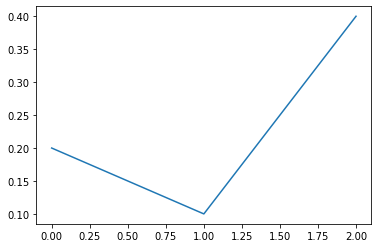

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeperiod,mse.values,data = mse)

##  Predicting user's total transactions from Spending profile & Social Network metrics
For each user’s lifetime point, regress her social network metrics and the
spending behavior of her social network on Y. Plot the MSE for each lifetime point like
above. Does the spending behavior of her social network add any predictive benefit
compared to Q10?

For this part we are just cosnidering - 

1. Degree as the social network metric
2. direct 'Friend' as the social network entity


In [ ]:

#in python
modeldata = pd.read_csv("modeldata_Venmo.csv")
modeldata['timeperiod'] = modeldata['timeperiod'].apply(np.int64)
model11 = pd.read_csv("model_q11.csv")
ds_full = pd.merge(modeldata, model11, on=['user1','timeperiod'], how='inner')
ds_full.rename(column = {'user2' = 'user1'})   #functioned define

nw_spend = pd.merge(ds_full, recency_frequency_tp, on=['user','timeperiod'], how='inner')
#timeperiod datasets
nw_spend1  = nw_spend[nw_spend['timperiod']==0]
nw_spend2  = nw_spend[nw_spend['timperiod']==2]
nw_spend3  = nw_spend[nw_spend['timperiod']==3]
nw_spend4  = nw_spend[nw_spend['timperiod']==4]
nw_spend5  = nw_spend[nw_spend['timperiod']==5]
nw_spend6  = nw_spend[nw_spend['timperiod']==6]
nw_spend7  = nw_spend[nw_spend['timperiod']==7]
nw_spend8  = nw_spend[nw_spend['timperiod']==8]
nw_spend9  = nw_spend[nw_spend['timperiod']==9]
nw_spend10  = nw_spend[nw_spend['timperiod']==10]
nw_spend11  = nw_spend[nw_spend['timperiod']==11]
nw_spend12  = nw_spend[nw_spend['timperiod']==12]

nw_spend_all = [nw_spend1  ,	nw_spend2 , 	nw_spend3  ,	nw_spend4  ,	nw_spend5 , 	nw_spend6 , 	nw_spend7 , 	nw_spend8  ,	nw_spend9  	nw_spend10  ,	nw_spend11 , 	nw_spend12  
]
mse = []
ts = 0
for nw in nw_spend_all:
  x = nw_spend_all[['degree_metric','frequency','recency','Food','Event','Travel','Activity','Utility','Cash','Illegal/Sarcasm','Unclassified','People','Transportation']]
  y = nw_spend_all[['Y_totatransactions_12month']]    
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
  regressor = LinearRegression()  
  regressor.fit(X_train, y_train) #training the algorithm
  y_pred = regressor.predict(X_test)
  mse[ts] = metrics.mean_squared_error(y_test, y_pred)
  ts = ts + 1
  plt.plot(timeperiod,mse.values,data = mse)

 